# Predicting Lung Cancer Survival Time

predict the survival time of a patient (remaining days to live) from one three-dimensional CT scan (grayscale image) and a set of pre-extracted quantitative imaging features, as well as clinical data

### $\color{green}{\text{ Importing Libraries }}$ 

In [0]:
import pandas as pd
import numpy as np
import missingno
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter, WeibullAFTFitter , LogNormalAFTFitter, LogLogisticAFTFitter , PiecewiseExponentialRegressionFitter
from lifelines.utils import k_fold_cross_validation
from IPython.display import HTML

In [2]:
!pip install lifelines

     |████████████████████████████████| 327kB 2.7MB/s 


## $\color{red}{\text{ Exploring Data}}$

## X Train 

## $\color{Blue}{\text {Features Exploration }}$

In [0]:
#Radiomic Training data 
df_Radiomics_train = pd.read_csv('/content/drive/My Drive/Fourth Semester/Predicting-lung-cancer-survival-time-master/data/xtrain/radiomics.csv',skiprows=[0,2], header=[0],index_col=0)
#Clinical Training data 
df_clinical_train = pd.read_csv('/content/drive/My Drive/Fourth Semester/Predicting-lung-cancer-survival-time-master/data/xtrain/clinical_data.csv',index_col=0)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
df_clinical_train.head() #the 5 first lines 

,Histology,Mstage,Nstage,SourceDataset,Tstage,age
PatientID,,,,,,
202,Adenocarcinoma,0,0,l2,2,66.0000
371,large cell,0,2,l1,4,64.5722
246,squamous cell carcinoma,0,3,l1,2,66.0452
240,nos,0,2,l1,3,59.3566
284,squamous cell carcinoma,0,3,l1,4,71.0554


## What missing values are there?

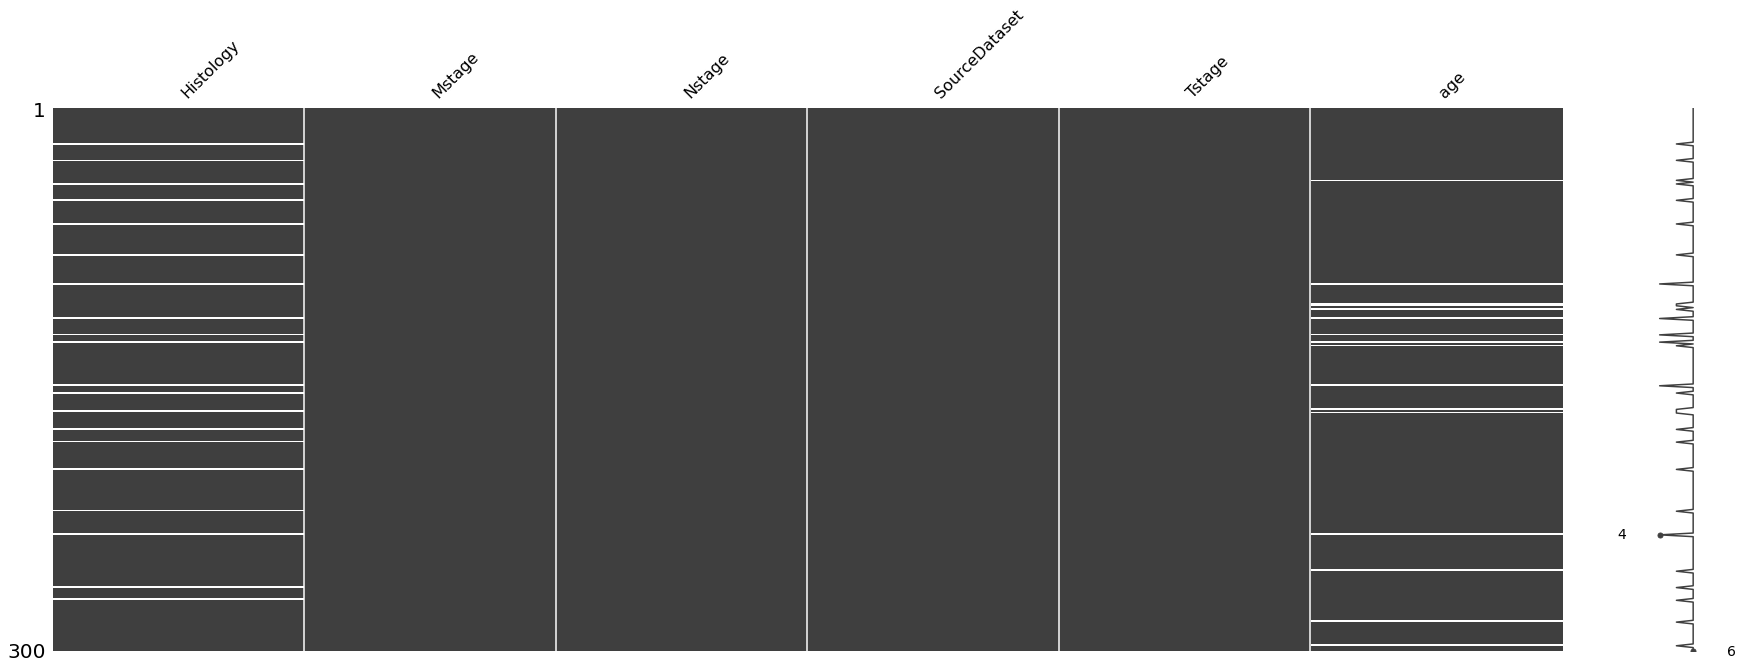

In [8]:
missingno.matrix(df_clinical_train, figsize = (30,10))

In [0]:
#We will use the age feature after filling the NaN values 
df_clinical_train = df_clinical_train.fillna(df_clinical_train.mean())

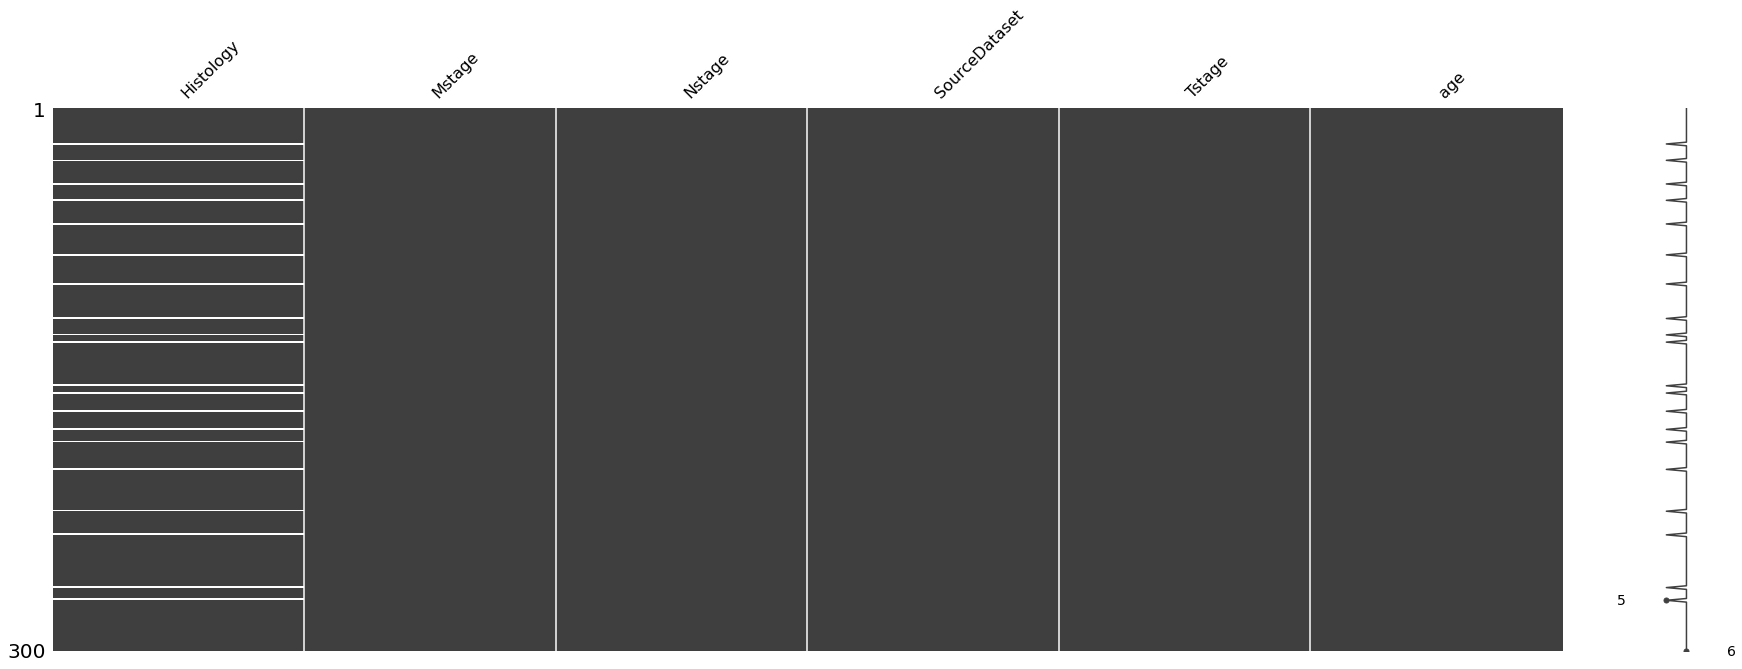

In [10]:
missingno.matrix(df_clinical_train, figsize = (30,10))

We will ignore the Histology feature

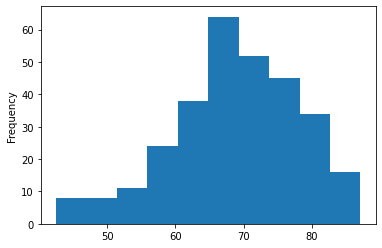

In [11]:
df_clinical_train.age.plot.hist()

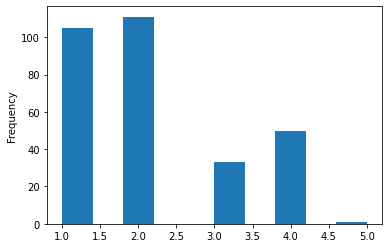

In [12]:
df_clinical_train.Tstage.plot.hist()

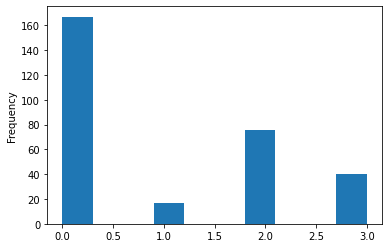

In [13]:
df_clinical_train.Nstage.plot.hist()

## Feature Encoding
Now we will encode the SourceDataset feature so it will be  ready to be used with our machine learning models.



In [0]:
encoder = LabelEncoder()
encoder.fit(df_clinical_train["SourceDataset"] )
df_clinical_train["SourceDataset"]= encoder.transform(df_clinical_train["SourceDataset"])

In [15]:
df_Radiomics_train.head()

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_StandardDeviation,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceEntropy,original_glcm_DifferenceAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_Id,original_glcm_Idm,original_glcm_Imc1,original_glcm_Imc2,original_glcm_Idmn,original_glcm_Idn,original_glcm_InverseVariance,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glrlm_ShortRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
202,0.027815,0.274892,48.559242,1.537964,0.650210,5431.333210,0.275228,19786.0,3.942944e+09,5.138062,1.592466,241.0,-310.858031,288.311105,-266.0,-1006.0,1247.0,446.407319,-0.281714,320.385361,0.037008,102646.779451,1056.843506,546253.499762,-5334.563631,555.818455,54.336816,0.821101,3.845383,5.036775,0.005920,9.270194,0.338672,0.262780,-0.175185,0.901525,0.981053,0.917509,0.249416,0.037768,61.035662,6.007130,0.926391,1.457980,555.378594,14592.303727,0.891330,0.003562,954.749135,0.003384,851.987373,0.004444,1651.710761
371,0.023015,0.188210,75.703368,1.744961,0.573079,10369.568729,0.240727,43168.0,3.122890e+09,4.461054,3.371013,262.0,-134.429809,191.395154,-15.0,-945.0,1207.0,268.966000,-1.216062,232.962090,0.080061,54271.335557,1219.689108,331155.230396,-6857.579704,295.032309,16.868781,0.891184,2.984034,2.570017,0.025532,7.551168,0.495719,0.439879,-0.250370,0.932847,0.993282,0.953464,0.340024,0.110575,67.826804,5.255594,0.855154,2.512125,1766.619373,22881.932686,0.766032,0.002246,1092.823724,0.002069,884.838627,0.003633,3386.995589
246,0.027348,0.265740,70.434367,1.555420,0.642913,10558.818691,0.200766,52655.0,1.059535e+09,3.437111,7.585494,115.0,-54.136093,94.132136,2.0,-785.0,900.0,141.852795,-2.153344,131.116356,0.160905,17191.498865,972.465798,54523.086867,-1618.363118,78.183970,7.040623,0.831081,2.333939,1.496020,0.066569,5.686554,0.616607,0.581458,-0.249969,0.884911,0.995095,0.963887,0.379957,0.189723,61.795144,4.159019,0.769265,4.096838,3462.816344,18773.106002,0.644554,0.001880,878.989601,0.001635,634.910036,0.004869,4232.418080
240,0.026811,0.255406,46.818800,1.576120,0.634469,4221.412123,0.323878,13074.0,6.583324e+08,4.352564,4.281865,274.0,-118.705522,149.072998,-37.0,-850.0,1124.0,224.397694,-1.437836,190.429315,0.074476,36263.324022,968.117567,166735.779994,-3968.921514,184.299591,13.656782,0.860096,2.926791,2.492079,0.015048,7.536161,0.457545,0.391681,-0.214233,0.902811,0.993509,0.950374,0.357236,0.050439,60.841486,5.122729,0.880123,1.824328,683.869792,7978.285176,0.828138,0.002855,907.045929,0.002680,774.885387,0.003901,1844.746046
284,0.023691,0.199424,53.795911,1.711620,0.584242,5295.900331,0.327241,16237.0,8.072532e+08,4.055700,8.999616,203.0,-67.201946,143.210231,14.0,-1023.0,1226.0,222.972850,-2.438490,212.604774,0.104419,45200.790098,1594.558416,658805.553990,-10509.915485,248.373464,20.121147,0.849653,2.787526,2.372269,0.029317,6.940307,0

In [16]:
df_Radiomics_train.isnull().sum().sum()

0

### Features Used 

- Tumor sphericity, a measure of the roundness of the shape of the tumor region relative to a sphere, regardless its dimensions (size)
- The tumor's surface to volume ratio is a measure of the compactness of the tumor, related to its size  
- The tumor's maximum 3d diameter The biggest diameter measurable from the tumor volume 
- The dataset of origin
- The N-tumoral stage grading of the tumor describing nearby (regional) lymph nodes involved
- The tumor's joint entropy, specifying the randomness in the image pixel values
- age
- Tstage
- The tumor's inverse different, a measure of the local homogeneity of the tumor
-  The tumor's inverse difference moment is another measurement of the local homogeneity of the tumor

In [0]:
df_X_train = pd.concat([df_Radiomics_train[["original_shape_Sphericity", "original_shape_SurfaceVolumeRatio", "original_shape_Maximum3DDiameter","original_firstorder_Entropy",
"original_glcm_Id","original_glcm_Idm"]],df_clinical_train[["SourceDataset","Nstage","Tstage","age"]]], axis=1)

## y Train

In [19]:
#The Training output 
df_y = pd.read_csv('/content/drive/My Drive/Fourth Semester/Predicting-lung-cancer-survival-time-master/data/y train/output_VSVxRFU.csv', index_col=0)
p0 = df_y.loc[202]
print("p0.Event", p0.Event)
print("p0.SurvivalTime", p0.SurvivalTime)

p0.Event 0
p0.SurvivalTime 1378


In [20]:
df_y.head()

,SurvivalTime,Event
PatientID,,
202,1378,0
371,379,1
246,573,1
240,959,0
284,2119,0


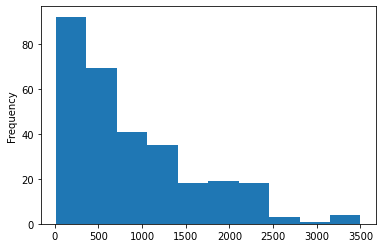

In [21]:
df_y.SurvivalTime.plot.hist()

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

#Visualise the counts of SibSp and the distribution of the values
#against Survived
#plot_count_dist(df_y, 
#              bin_df=df_bin, 
#              label_column='SurvivalTime', 
#              target_column='Event', 
#              figsize=(10, 5))

## $\color{red}{\text {Start Building Machine Learning Models}}$
Now our data has been manipulating and converted to numbers, we can run the machine learning Models.

## CoxPHFitter 

In [0]:
cph = CoxPHFitter().fit(pd.concat([df_X_train, df_y], axis = 1),duration_col = 'SurvivalTime', event_col='Event') 

In [27]:
cph.print_summary()

 Although using Cox proportional hazard model has come to the fore by most researchers in medical and cancer fields, results of accelerated failure-time models have often been more valid and have had minor bias since these models have better fitness in similar conditions due to a specific statistical distribution for the survival time and their not having need to PH assumption. Accelerated failure-time models will also be reliable alternatives to Cox proportional hazard model where this assumption is not made. In addition, accelerated failure-time models may offer some benefits.
 Based on asymptotic results, accelerated failure-time models lead to more efficient parameters than proportional hazard model. With a reduction in sample size, relative efficiency may further change in favor of accelerated failure-time models. When empirical information is adequate, accelerated failure-time models can prepare some insights into the form of the baseline hazard.

From paper : A Comparison between Accelerated Failure-time and Cox Proportional Hazard Models in Analyzing the Survival of Gastric Cancer Patients
### $\color{red}{\text { Let's try it out}}$

## WeibullAFTFitter

In [0]:
Wei = WeibullAFTFitter().fit(pd.concat([df_X_train, df_y], axis = 1),duration_col = 'SurvivalTime', event_col='Event') 

In [31]:
Wei.print_summary()

## LogNormalAFTFitter 

In [0]:
log = LogNormalAFTFitter().fit(pd.concat([df_X_train, df_y], axis = 1),duration_col = 'SurvivalTime', event_col='Event') 

In [33]:
log.print_summary()

## LogLogisticAFTFitter

In [0]:
logistic = LogLogisticAFTFitter().fit(pd.concat([df_X_train, df_y], axis = 1),duration_col = 'SurvivalTime', event_col='Event') 

In [35]:
logistic.print_summary

<bound method ParametricRegressionFitter.print_summary of <lifelines.LogLogisticAFTFitter: fitted with 300 total observations, 138 right-censored observations>>

## Concordance_index

In [0]:
df = pd.concat([df_X_train, df_y], axis = 1)

In [37]:
cox_cv_result = k_fold_cross_validation(cph, df, duration_col='SurvivalTime', event_col='Event', k=5)
print('CoxPHFitter C-index(cross-validation) = ', np.mean(cox_cv_result))

CoxPHFitter C-index(cross-validation) =  -1.8775976078648917


In [38]:
cox_cv_result = k_fold_cross_validation(Wei, df, duration_col='SurvivalTime', event_col='Event', k=5)
print('WeibullAFTFitter C-index(cross-validation) = ', np.mean(cox_cv_result))

WeibullAFTFitter C-index(cross-validation) =  -4.405801451794508


In [39]:
cox_cv_result = k_fold_cross_validation(log, df, duration_col='SurvivalTime', event_col='Event', k=5)
print('LogNormalAFTFitter C-index(cross-validation) = ', np.mean(cox_cv_result))

LogNormalAFTFitter C-index(cross-validation) =  -4.379755266141447


In [40]:
cox_cv_result = k_fold_cross_validation(logistic, df, duration_col='SurvivalTime', event_col='Event', k=5)
print(' C-index(cross-validation) = ', np.mean(cox_cv_result))

 C-index(cross-validation) =  -4.392471637194239


## $\color{red}{\text{ Submission}}$

## X Test

In [0]:
df_Radiomics_test = pd.read_csv('/content/drive/My Drive/Fourth Semester/Predicting-lung-cancer-survival-time-master/data/x test/radiomics.csv',skiprows=[0,2], header=[0],index_col=0)
df_clinical_test = pd.read_csv('/content/drive/My Drive/Fourth Semester/Predicting-lung-cancer-survival-time-master/data/x test/clinical_data.csv',index_col=0)

In [0]:
#fill the NaN values of age 
df_clinical_test = df_clinical_test.fillna(df_clinical_test.mean())

In [0]:
encoder = LabelEncoder()
encoder.fit(df_clinical_test["SourceDataset"])
df_clinical_test["SourceDataset"] = encoder.transform(df_clinical_test["SourceDataset"])

In [0]:
df_X_test = pd.concat([df_Radiomics_test[["original_shape_Sphericity", "original_shape_SurfaceVolumeRatio", "original_shape_Maximum3DDiameter","original_firstorder_Entropy",
"original_glcm_Id","original_glcm_Idm"]],df_clinical_test[["SourceDataset","Nstage","Tstage","age"]]], axis=1)

In [61]:
df = pd.concat([df_X_train, df_y], axis = 1)
concordance_index(df['SurvivalTime'], -cph.predict_partial_hazard(df), df['Event'])

0.7044347441007148

## Lifetime prediction

In [0]:
lifetime_prediction = log.predict_expectation(df_X_test)
lifetime_prediction.columns = ['SurvivalTime']
lifetime_prediction.index.names = ['PatientID']
lifetime_prediction['Event'] = 'NaN'

In [0]:
def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

lifetime_prediction.to_csv('/content/drive/My Drive/Fourth Semester/Predicting-lung-cancer-survival-time-master/Submission/submission.csv')
create_download_link(filename='submission.csv')

## $\color{black}{\text{ Still working on it }}$

### Exploring Images data

In [51]:
archive = np.load( '/content/drive/My Drive/Fourth Semester/Ai/AI Project/train_images /images/patient_003.npz')
scan = archive['scan']
mask = archive['mask']
print(scan.shape)

(92, 92, 92)


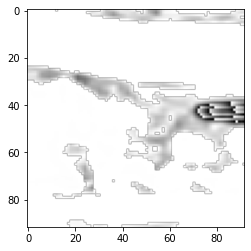

In [56]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
plt.figure()
plt.ion()

#archive.shape
#imshow(img)
#plt.imshow(Image.fromarray(scan, 'RGBA'))
#plt.imshow(Image.fromarray(scan, 'CMYK'))
#plt.imshow(Image.fromarray(mask, 'LA'))
plt.imshow(Image.fromarray(scan, 'LA'))

In [0]:
def logprediction(y_true_times) :
    y_true_times.columns = ['SurvivalTime']
    y_true_times.index.names = ['PatientID']
    y_true_times['Event'] = 0
    return(y_pred) 